In [23]:
%reload_ext autoreload
%autoreload 2
# load dataset 
import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_utils
import RS_models

In [24]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

In [6]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}

In [7]:
#-- dataset
dataset = RS_dataset.Seg_RS_dataset_edge_v3(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP,gaussian=False,mask_onehot=False,softmax=False)

In [8]:
img, mask, _, edge = dataset.__getitem__(np.random.randint(0,400))

In [9]:
mask.shape

torch.Size([3, 256, 256])

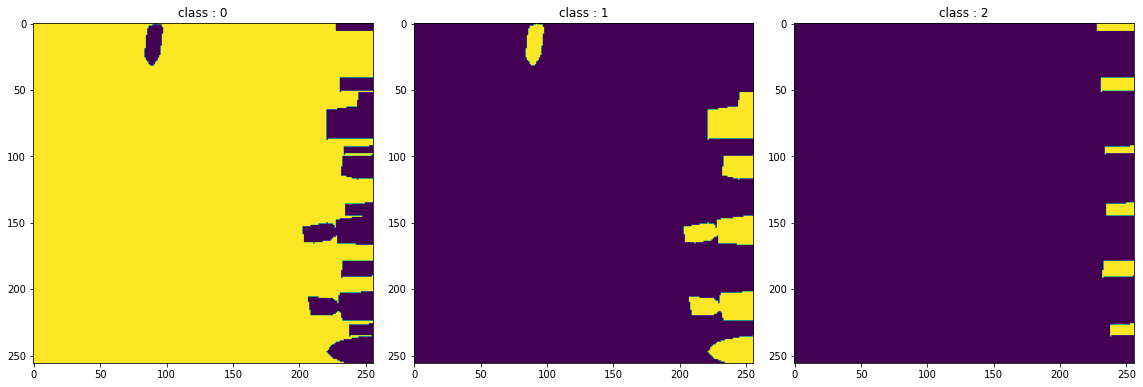

In [10]:
RS_utils.label_display(mask, n_class=3, nrows=1 , ncols=3, channel_order='torch', batch=False)

In [11]:
edge.shape

torch.Size([1, 256, 256])

In [12]:
torch.unique(edge)

tensor([0, 1])

In [13]:
edge_ = RS_utils.apply_one_hot(edge, 2, batch=False)

In [14]:
edge_.shape

torch.Size([1, 2, 256, 256])

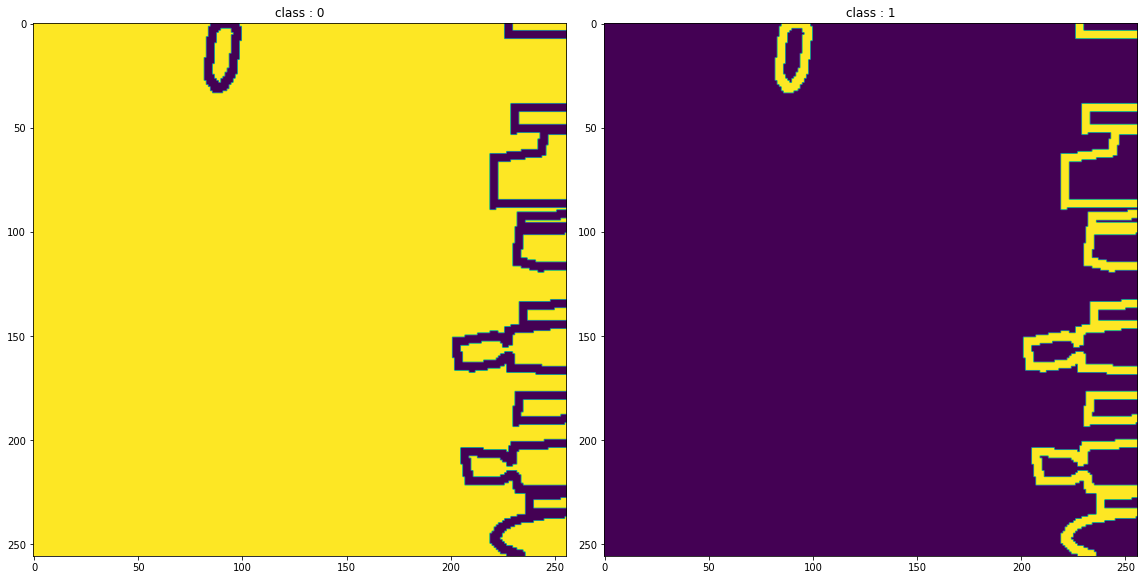

In [15]:
RS_utils.label_display(edge_, n_class=2, nrows=1 , ncols=2, channel_order='torch', batch=True)

In [16]:
aa = "./02.ckpts"

w_path = sorted(glob(os.path.join(aa, "*.pt")))[-1]
#w_path ="/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/06.Edge_Net_Reproduction_1/02.ckpts/ver_81_EDGE_EDGE_NET_epoch_101_iteration_118776.pt"
print(w_path)
weights_ = torch.load(w_path, map_location=torch.device('cpu'))

model = RS_models.Edge_Net(input_channel=3,output_channel=1)
model.load_state_dict(weights_)
model = model.eval()

./02.ckpts/ver_85_EDGE_EDGE_NET_epoch_81_iteration_6081318.pt


In [17]:
mask = mask.float()
pred = model(mask)

In [18]:
pred.shape

torch.Size([1, 256, 256])

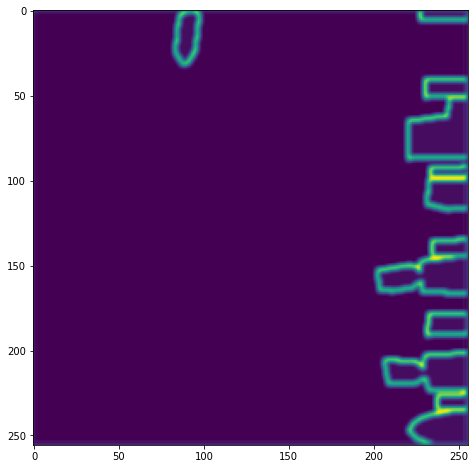

In [19]:
pred = pred.detach().cpu()
pred = pred.permute(1,2,0)
plt.figure(figsize=(8,8))
plt.imshow(pred)